# XAI(Explainable Artificial Intelligence)
- 설명 가능한 AI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/03-data-processing/data/"
SEED = 42

In [ ]:
# 아래 복붙
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
df = pd.read_csv(f"{DATA_PATH}titanic.csv")
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]
# 범주형 one-hot encoding
cols = ["gender","embarked"]
enc = OneHotEncoder()
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
features = pd.concat([features,tmp],axis=1) # 특성
target = df["survived"] # 정답값
features.head()

,pclass,age,sibsp,parch,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


- holdout 으로 학습및 검증 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(features,target,random_state=SEED)

x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((981, 10), (328, 10), (981,), (328,))

- lgbm 으로 학습 및 검증 평가

In [ ]:
from lightgbm import LGBMClassifier,plot_importance
from sklearn.metrics import roc_auc_score

model = LGBMClassifier(random_state = SEED)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.9081257023288255

- 특성 중요도 확인하기

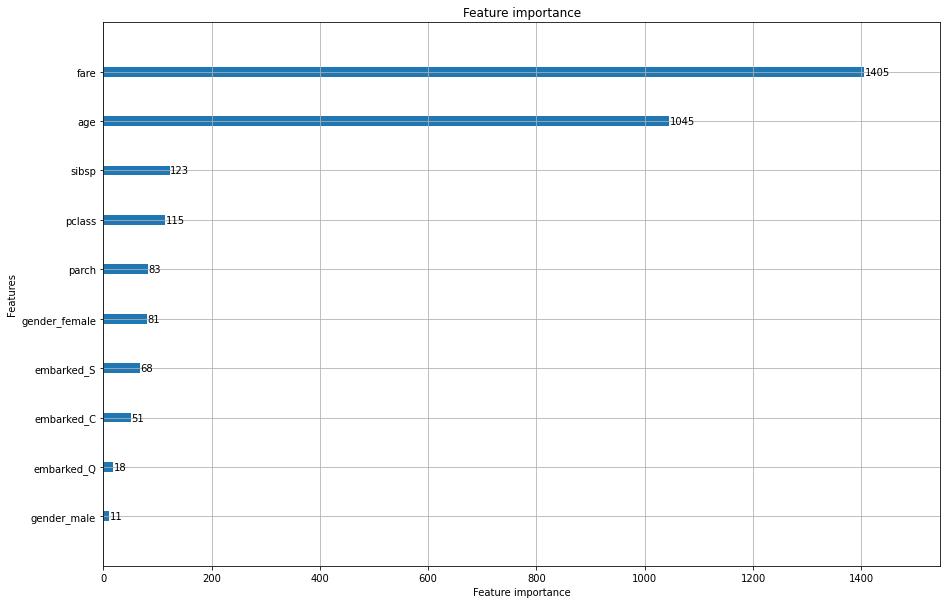

In [ ]:
import matplotlib.pyplot as plt
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model,ax=ax)
plt.show()

# SHAP(Shapley Additive exPlanations)
- Shapley Value와 피쳐간 독립성을 핵심 아이디어로 사용하는 기법
- Shapley Value는 게임 이론을 바탕으로 각 피쳐의 기여도를 계산하는 방법
- SHAP의 목적은 예측에 대한 각 피쳐의 기여도를 계산하여 관측치(X) 의 예측값을 설명 하는것

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.4 MB/s 


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model) # 학습된 모델을 넣는다.
shap_values = explainer.shap_values(x_valid)

In [ ]:
len(shap_values)

2

In [ ]:
shap_values[1].shape , x_valid.shape

((328, 10), (328, 10))

- force_plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1][-1,:],x_valid.iloc[-1,:])

- summary_plot

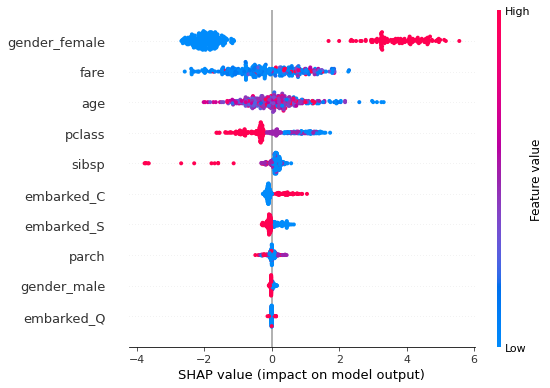

In [ ]:
shap.summary_plot(shap_values[1],x_valid)

- dependence_plot

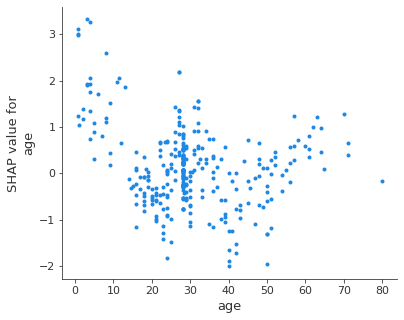

In [ ]:
shap.dependence_plot("age",shap_values[1],x_valid,interaction_index=None)

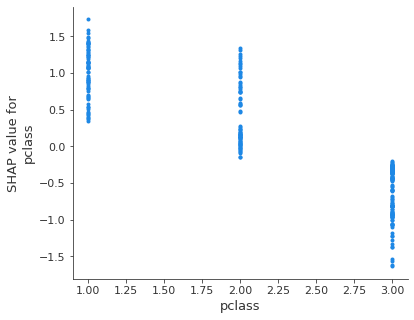

In [ ]:
shap.dependence_plot("pclass",shap_values[1],x_valid,interaction_index=None)

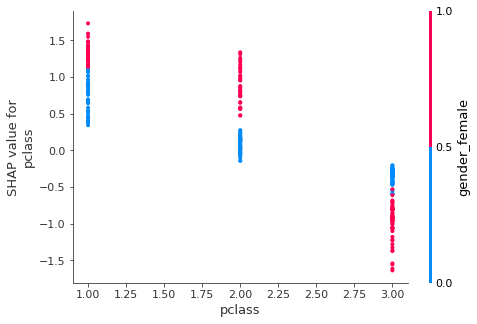

In [ ]:
shap.dependence_plot("pclass",shap_values[1],x_valid,interaction_index="auto")

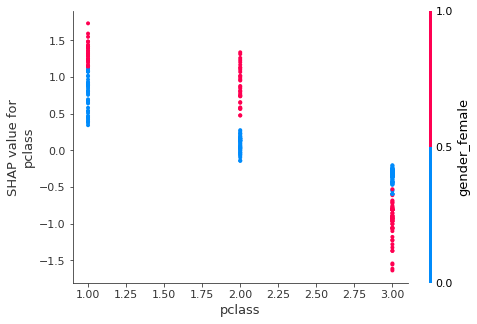

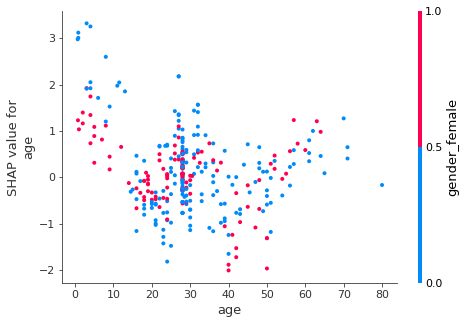

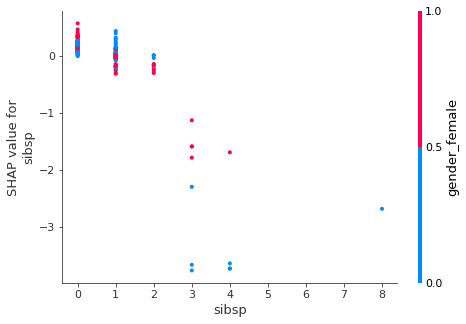

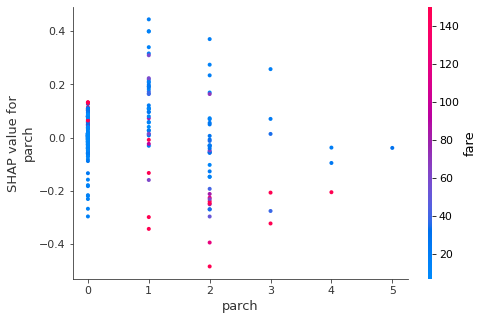

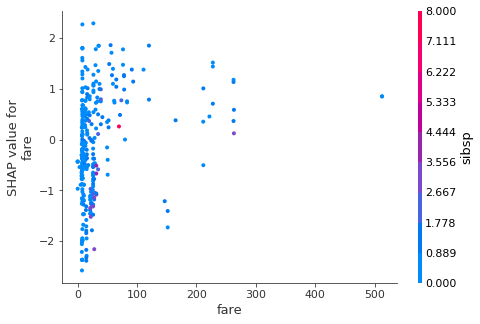

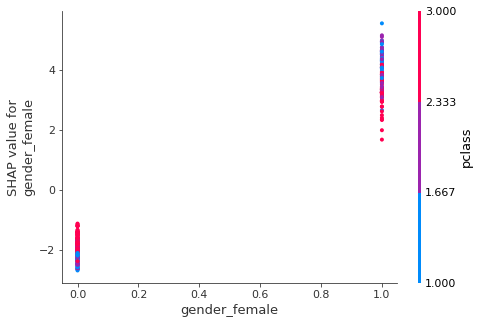

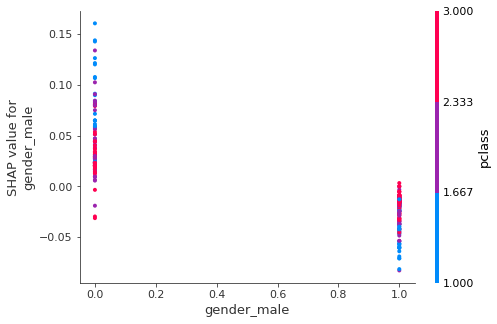

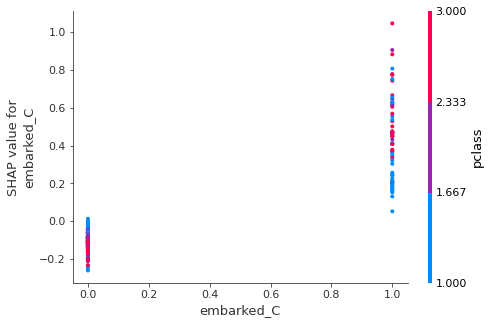

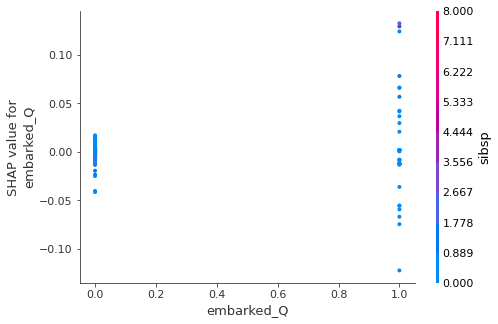

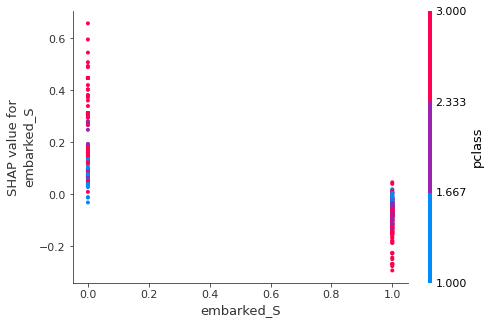

In [ ]:
for col in x_valid.columns:
    shap.dependence_plot(col,shap_values[1],x_valid)
    print()

- https://shap.readthedocs.io/en/latest/index.html